In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import os
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import random_split, DataLoader

### Building CNN class

In [2]:
class MyCNN_alexnet(nn.Module):
    def __init__(self):
        super(MyCNN_alexnet, self).__init__()
        # input size = 227x227x3
        # Give size after each layer 


        self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2) # 27x27x256
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride = 1, padding = 1) # 27x27x384
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride = 1, padding = 1) # 27x27x384
        self.conv5 = nn.Conv2d(in_channels= 384, out_channels=256, kernel_size =3, stride = 1, padding=1 ) # 27x27x256
        self.fc1 = nn.Linear(in_features=6*6*256, out_features=4096) # 4096
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096) # 4096
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(in_features=4096, out_features=1) # 1000
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x) # 55x55x96
        x = self.relu(x)
        x = self.pool(x) # 27x27x96
        x = self.conv2(x) # 27x27x256   
        x = self.relu(x)
        x = self.pool(x) # 13x13x256
        x = self.conv3(x) # 13x13x384
        x = self.relu(x)
        x = self.conv4(x) # 13x13x384
        x = self.relu(x)
        x = self.pool(x) #6x6x384
        x = self.conv5(x) # 6x6x256   
        x = self.relu(x)
        # x = self.pool(x) # 6x6x256
        x = x.view(-1, 6*6*256)
        x = self.fc1(x) # 4096
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x) # 4096
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x) # 1000
        x = torch.nn.functional.softmax(x, dim=1)
        return x

In [51]:
model = MyCNN_alexnet()
print(model)
# print(model.train()) # model.train() == model
print(summary(model, (1, 227, 227)))


MyCNN_alexnet(
  (conv1): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=4096, out_features=1, bias=True)
  (relu): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          11,712
              ReLU-2           [-1

### DataLoader

In [52]:
# Step 1: Define Transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
    
])

# Step 2: Load dataset using ImageFolder
dataset = datasets.ImageFolder(root="Animal_Images", transform=transform)

train_size = int(0.02 * len(dataset))
test_size = int(0.01 * len(dataset))
val_size = len(dataset) - train_size - test_size
# test_size = len(dataset) - train_size

train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Step 3: Create DataLoader
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [53]:
# Step 4: Class labels
print(dataset.classes)  # ['cats', 'dogs']

['cats', 'dogs']


## Data Visualization

torch.Size([64, 1, 227, 227])
tensor([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0])


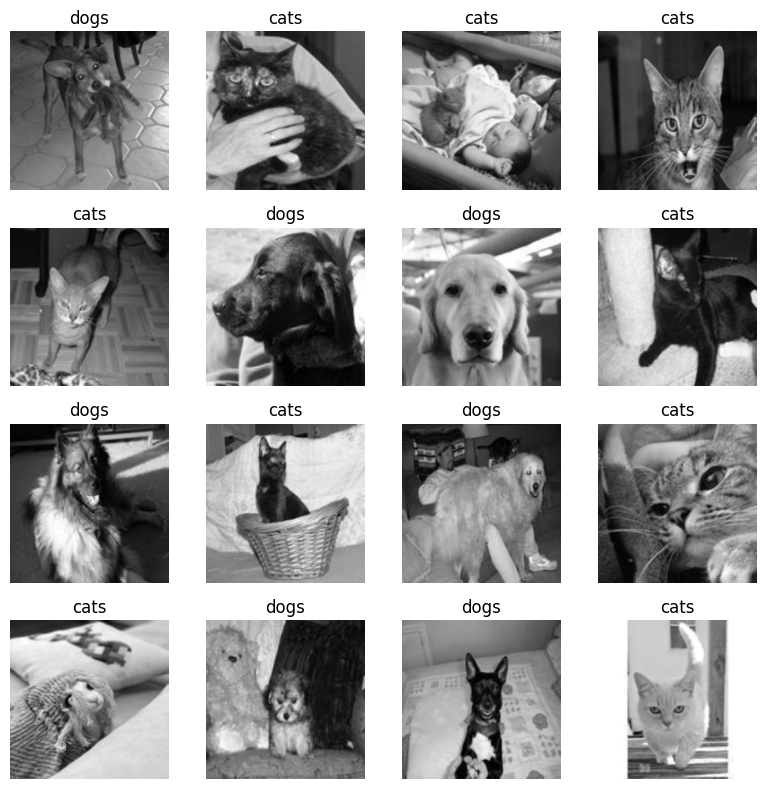

In [55]:
# Step 5: Iterate and visualize a batch
images, labels = next(iter(train_loader))
print(images.shape)     # [16, 3, 128, 128]
print(labels) 

def show_images(images, labels, class_names):
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axs.flatten()):
        img = images[i].permute(1, 2, 0).numpy()  # [C,H,W] -> [H,W,C]
        ax.imshow(img, cmap='gray')
        ax.set_title(class_names[labels[i]])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_images(images, labels, dataset.classes)

## Set up the loss function and optimizer ##

In [56]:
import torch
from tqdm import tqdm
model = MyCNN_alexnet()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


## Model Training Loop

In [57]:
num_epochs = 15
best_test_acc = 0
resume = False
train_accuracy, test_accuracy, train_losss, test_losss = [], [], [], []
# Load latest saved checkpoint if resume is True
if resume and os.path.exists('model.pth'):
    print('i m in resume --> ')
    checkpoint = torch.load('model.pth', map_location='cpu')  # use 'cuda' if on GPU
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    

for epoch in range(num_epochs):
    model.train()
    running_loss= 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.float().unsqueeze(1) 
        losss = criterion(outputs, labels)
        losss.backward()
        optimizer.step()
        running_loss += losss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    train_losss.append(train_loss)
    train_accuracy.append(train_acc)

    # Evaluation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            labels = labels.float().unsqueeze(1) 
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    
    test_losss.append(test_loss)
    test_accuracy.append(test_acc)


    if test_acc > best_test_acc:
        best_test_acc = test_acc
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        }
        torch.save(checkpoint, 'model.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    if best_test_acc > 90:
        print('Early stopping criteria met')
        break

100%|██████████| 10/10 [00:30<00:00,  3.06s/it]


Epoch [1/15] Train Loss: 0.7873, Train Acc: 52.92% Test Loss: 0.8296, Test Acc: 48.49%


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


Epoch [2/15] Train Loss: 0.7734, Train Acc: 52.92% Test Loss: 0.8296, Test Acc: 48.49%


100%|██████████| 10/10 [00:24<00:00,  2.50s/it]


Epoch [3/15] Train Loss: 0.7929, Train Acc: 52.92% Test Loss: 0.8296, Test Acc: 48.49%


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


Epoch [4/15] Train Loss: 0.7929, Train Acc: 52.92% Test Loss: 0.8296, Test Acc: 48.49%


100%|██████████| 10/10 [00:33<00:00,  3.34s/it]


Epoch [5/15] Train Loss: 0.7929, Train Acc: 52.92% Test Loss: 0.8296, Test Acc: 48.49%


100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


Epoch [6/15] Train Loss: 0.7873, Train Acc: 52.92% Test Loss: 0.8296, Test Acc: 48.49%


100%|██████████| 10/10 [00:32<00:00,  3.21s/it]


Epoch [7/15] Train Loss: 0.7790, Train Acc: 52.92% Test Loss: 0.8296, Test Acc: 48.49%


100%|██████████| 10/10 [00:33<00:00,  3.40s/it]


Epoch [8/15] Train Loss: 0.7845, Train Acc: 52.92% Test Loss: 0.8296, Test Acc: 48.49%


100%|██████████| 10/10 [00:31<00:00,  3.15s/it]


Epoch [9/15] Train Loss: 0.7762, Train Acc: 52.92% Test Loss: 0.8296, Test Acc: 48.49%


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


Epoch [10/15] Train Loss: 0.7873, Train Acc: 52.92% Test Loss: 0.8296, Test Acc: 48.49%


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


Epoch [11/15] Train Loss: 0.7873, Train Acc: 52.92% Test Loss: 0.8296, Test Acc: 48.49%


100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


Epoch [12/15] Train Loss: 0.7790, Train Acc: 52.92% Test Loss: 0.8296, Test Acc: 48.49%


100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


Epoch [13/15] Train Loss: 0.7845, Train Acc: 52.92% Test Loss: 0.8296, Test Acc: 48.49%


100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


Epoch [14/15] Train Loss: 0.7706, Train Acc: 52.92% Test Loss: 0.8296, Test Acc: 48.49%


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


Epoch [15/15] Train Loss: 0.7790, Train Acc: 52.92% Test Loss: 0.8296, Test Acc: 48.49%


## Learning Curves

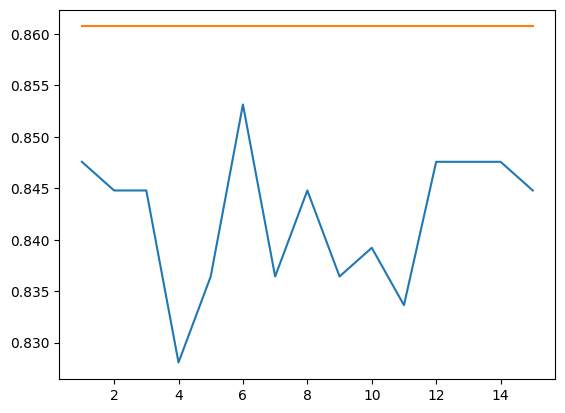

In [49]:
# train_accuracy, test_accuracy, train_losss, test_losss
plt.plot(range(1, 16), train_losss)
plt.plot(range(1, 16), test_losss)
plt.show()

In [61]:
# Suppose your model is called 'model'
# torch.save(model.state_dict(), 'model.pth')

In [31]:
# Load the saved weights
# model.load_state_dict(torch.load('model.pth'))
checkpoint = torch.load('model.pth')
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

### Model Evaluation ##

In [35]:
# 3. Predict
from PIL import Image
from torchvision import transforms

# Example: Load and preprocess an image
img = Image.open('images.jpg')
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1),
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])
img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

with torch.no_grad():
    output = model(img_tensor)
    predicted_class = torch.argmax(output, dim=1)
    print("Predicted class:", predicted_class.item())

Predicted class: 0


In [30]:
print(dataset.classes)
torch.cuda.is_available()

['cats', 'dogs']


False

In [33]:
import os
list_images = os.listdir('Animal_Images/cats')
len(list_images)

14995

In [35]:
test_loader

In [46]:
a = list(range(1, 10))
b = list(range(2, 20, 2))
a, b

([1, 2, 3, 4, 5, 6, 7, 8, 9], [2, 4, 6, 8, 10, 12, 14, 16, 18])

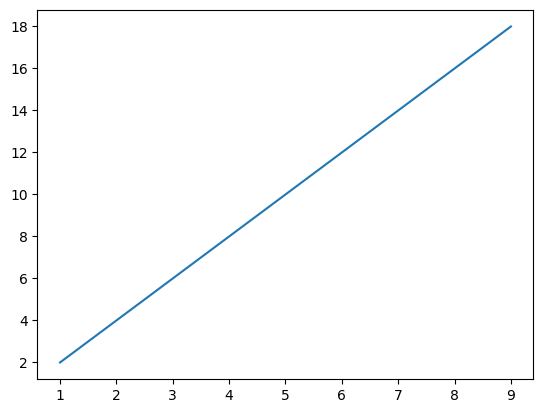

In [47]:
plt.plot(a,b)